# EmployeePayHistory

## Import the necessary libraries

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from training.common_functions import drop_sk_datetime_added_columns as drop_columns, train_model, get_engine, plot_predictions, plot_feature_importance, \
    read_data_return_df
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import torch

## Connecting to the database
Connecting to the UnitedOutdoors sql server database and reading the data from the EmployeePayHistory table

In [2]:
engine = get_engine()

Connection to UnitedOutdoors database successful


## Reading in the data

In [3]:
sql_query_workorder = "SELECT * FROM WorkOrder"
workorder_df = read_data_return_df(sql_query_workorder, engine)

workorder_df.head()

,WORKORDER_sk,WORKORDER_WORKORDER_WorkOrderID,WORKORDER_WORKORDER_ProductID,WORKORDER_WORKORDER_OrderQty,WORKORDER_WORKORDER_StockedQty,WORKORDER_WORKORDER_ScrappedQty,WORKORDER_WORKORDER_StartDate,WORKORDER_WORKORDER_EndDate,WORKORDER_WORKORDER_DueDate,WORKORDER_WORKORDER_ScrapReasonID,...,WORKORDER_WORKORDERINGROUTING_ScheduledStartDate,WORKORDER_WORKORDERINGROUTING_ScheduledEndDate,WORKORDER_WORKORDERINGROUTING_ActualStartDate,WORKORDER_WORKORDERINGROUTING_ActualEndDate,WORKORDER_WORKORDERINGROUTING_ActualResourcesHrs,WORKORDER_WORKORDERINGROUTING_PlannedCost,WORKORDER_WORKORDERINGROUTING_ActualCost,WORKORDER_SCRAPREASON_ScrapReasonID,WORKORDER_SCRAPREASON_Name,WORKORDER_datetime_added
0,1,41,191,98,97,1,2011-06-03,2011-06-19,2011-06-14,None,...,2011-06-03,2011-06-14,2011-06-03,2011-06-19,3.0,36.75,36.75,7,Handling damage,2024-05-28 09:40:43.403
1,2,41,191,98,97,1,2011-06-03,2011-06-19,2011-06-14,None,...,2011-06-03,2011-06-14,2011-06-03,2011-06-19,4.0,49.00,49.00,7,Handling damage,2024-05-28 09:40:43.403
2,3,69,1055,120,117,3,2011-06-03,2011-06-19,2011-06-14,None,...,2011-06-03,2011-06-14,2011-06-03,2011-06-19,4.1,92.25,92.25,11,Stress test failed,2024-05-28 09:40:43.403
3,4,69,1055,120,117,3,2011-06-03,2011-06-19,2011-06-14,None,...,2011-06-03,2011-06-14,2011-06-03,2011-06-19,3.5,87.50,87.50,11,Stress test failed,2024-05-28 09:40:43.407
4,5,69,1055,120,117,3,2011-06-03,2011-06-19,2011-06-14,None,...,2011-06-03,2011-06-14,2011-06-03,2011-06-19,3.0,36.75,36.75,11,Stress test failed,2024-05-28 09:40:43.407


## Data Cleaning

In [4]:
# dropping unnecessary columns
columns_to_keep = ['WORKORDER_sk', 'WORKORDER_WORKORDER_ProductID', 'WORKORDER_WORKORDER_OrderQty', 'WORKORDER_WORKORDER_StockedQty', 'WORKORDER_WORKORDER_StartDate', 'WORKORDER_WORKORDER_EndDate', 'WORKORDER_WORKORDER_DueDate', 'WORKORDER_WORKORDERINGROUTING_OperationSequence', 'WORKORDER_WORKORDERINGROUTING_LocationID', 'WORKORDER_WORKORDERINGROUTING_PlannedCost', 'WORKORDER_WORKORDERINGROUTING_ActualCost']

combined_df = workorder_df[columns_to_keep]

In [5]:
# Convert the datetime column to number of days since Unix epoch
combined_df['WORKORDER_WORKORDER_StartDate'] = pd.to_datetime(combined_df['WORKORDER_WORKORDER_StartDate'], errors='coerce').astype('int64')
combined_df['WORKORDER_WORKORDER_EndDate'] = pd.to_datetime(combined_df['WORKORDER_WORKORDER_EndDate'], errors='coerce').astype('int64')
combined_df['WORKORDER_WORKORDER_DueDate'] = pd.to_datetime(combined_df['WORKORDER_WORKORDER_DueDate'], errors='coerce').astype('int64')

# Convert PRODUCTID to category
combined_df['WORKORDER_WORKORDER_ProductID'] = combined_df['WORKORDER_WORKORDER_ProductID'].astype('category').cat.codes


In [6]:
# fixing null values
drop_columns(combined_df)

In [7]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 10 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   WORKORDER_WORKORDER_ProductID                    383 non-null    int8   
 1   WORKORDER_WORKORDER_OrderQty                     383 non-null    int64  
 2   WORKORDER_WORKORDER_StockedQty                   383 non-null    int64  
 3   WORKORDER_WORKORDER_StartDate                    383 non-null    int64  
 4   WORKORDER_WORKORDER_EndDate                      383 non-null    int64  
 5   WORKORDER_WORKORDER_DueDate                      383 non-null    int64  
 6   WORKORDER_WORKORDERINGROUTING_OperationSequence  383 non-null    int64  
 7   WORKORDER_WORKORDERINGROUTING_LocationID         383 non-null    int64  
 8   WORKORDER_WORKORDERINGROUTING_PlannedCost        383 non-null    float64
 9   WORKORDER_WORKORDERINGROUTING_Ac

In [8]:
combined_df.head()

,WORKORDER_WORKORDER_ProductID,WORKORDER_WORKORDER_OrderQty,WORKORDER_WORKORDER_StockedQty,WORKORDER_WORKORDER_StartDate,WORKORDER_WORKORDER_EndDate,WORKORDER_WORKORDER_DueDate,WORKORDER_WORKORDERINGROUTING_OperationSequence,WORKORDER_WORKORDERINGROUTING_LocationID,WORKORDER_WORKORDERINGROUTING_PlannedCost,WORKORDER_WORKORDERINGROUTING_ActualCost
0,4,98,97,1307059200000000000,1308441600000000000,1308009600000000000,6,13,36.75,36.75
1,4,98,97,1307059200000000000,1308441600000000000,1308009600000000000,7,14,49.00,49.00
2,52,120,117,1307059200000000000,1308441600000000000,1308009600000000000,1,8,92.25,92.25
3,52,120,117,1307059200000000000,1308441600000000000,1308009600000000000,2,9,87.50,87.50
4,52,120,117,1307059200000000000,1308441600000000000,1308009600000000000,6,13,36.75,36.75


## Data Analysis
Predicting the rate of pay for employees based on the other columns, using a variety of models

### Splitting the data

In [9]:
# splitting the data
X = combined_df.drop(columns=['WORKORDER_WORKORDERINGROUTING_ActualCost'])
y = combined_df['WORKORDER_WORKORDERINGROUTING_ActualCost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [10]:
# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# fitting the model
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [12]:
# predicting the values
lr_y_pred = lr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [13]:
# calculating the metrics
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

print(f'Mean Squared Error: {lr_mse}')
print(f'R2 Score: {lr_r2}')

Mean Squared Error: 4.2307532392216755e-28
R2 Score: 1.0


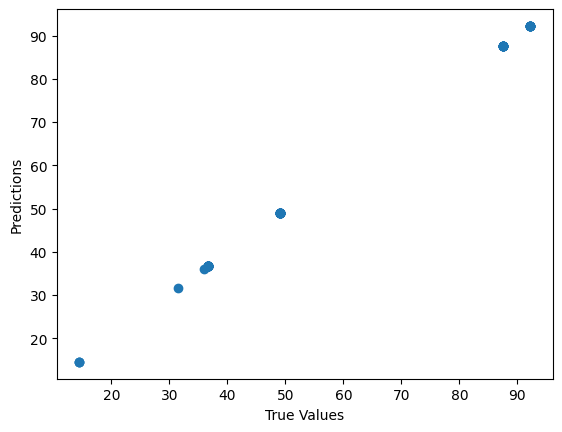

In [14]:
# visualizing the results
plt.scatter(y_test, lr_y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [15]:
# dataframe with the predictions and the actual values, plus other metrics
lr_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_y_pred})
lr_results['Difference'] = lr_results['Actual'] - lr_results['Predicted']
lr_results['Absolute Difference'] = np.abs(lr_results['Difference'])
lr_results['Squared Difference'] = lr_results['Difference'] ** 2

lr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
268,36.75,36.75,0.000000e+00,0.000000e+00,0.000000e+00
250,36.75,36.75,0.000000e+00,0.000000e+00,0.000000e+00
318,49.00,49.00,0.000000e+00,0.000000e+00,0.000000e+00
331,36.75,36.75,0.000000e+00,0.000000e+00,0.000000e+00
56,36.75,36.75,7.105427e-15,7.105427e-15,5.048710e-29
...,...,...,...,...,...
104,87.50,87.50,-2.842171e-14,2.842171e-14,8.077936e-28
167,87.50,87.50,-2.842171e-14,2.842171e-14,8.077936e-28
63,49.00,49.00,0.000000e+00,0.000000e+00,0.000000e+00
233,36.75,36.75,1.421085e-14,1.421085e-14,2.019484e-28


### Decision Tree Regressor

In [16]:
# fitting the model
dtr_model = DecisionTreeRegressor(max_depth=5)

dtr_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=5)

In [17]:
# predicting the values
dtr_y_pred = dtr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [18]:
# calculating the metrics
dtr_mse = mean_squared_error(y_test, dtr_y_pred)
dtr_r2 = r2_score(y_test, dtr_y_pred)
print(f'Mean Squared Error: {dtr_mse}')
print(f'R2 Score: {dtr_r2}')

Mean Squared Error: 0.0
R2 Score: 1.0


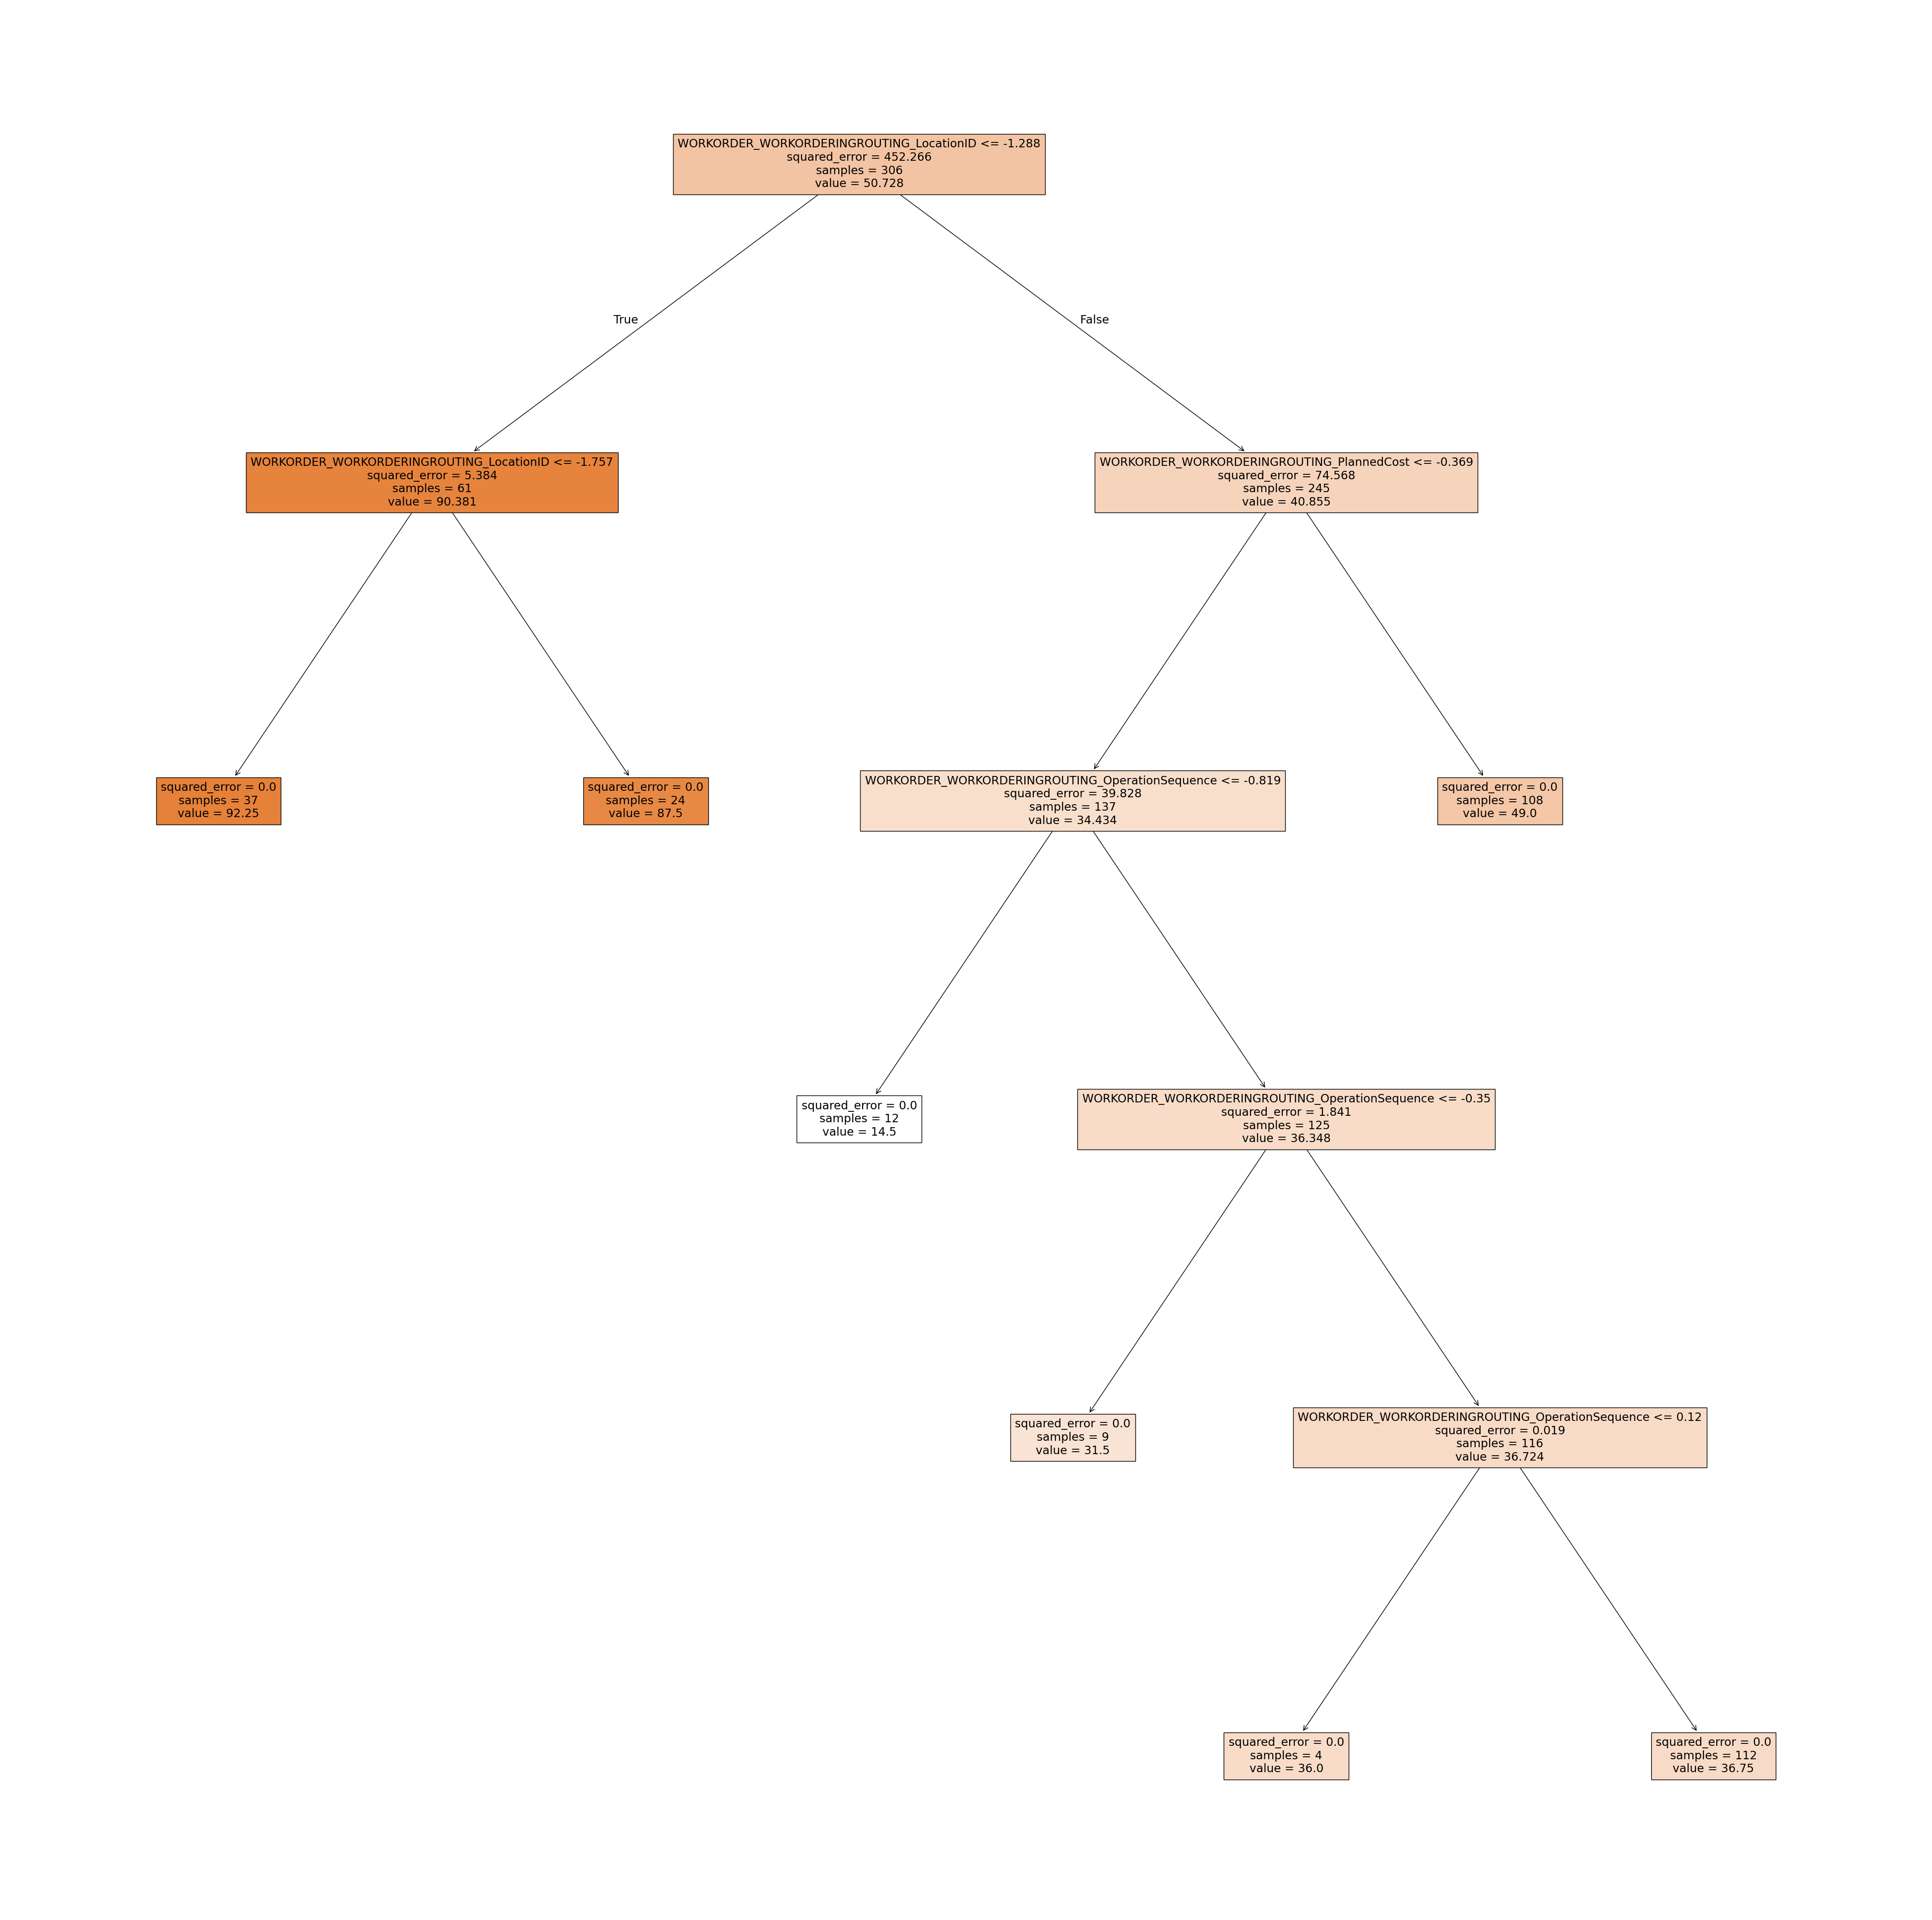

In [19]:
# visualizing the decision tree
plt.figure(figsize=(50, 50))
plot_tree(dtr_model, filled=True, feature_names=X.columns)
plt.show()

In [20]:
# dataframe with the predictions and the actual values, plus other metrics
dtr_results = pd.DataFrame({'Actual': y_test, 'Predicted': dtr_y_pred})
dtr_results['Difference'] = dtr_results['Actual'] - dtr_results['Predicted']
dtr_results['Absolute Difference'] = np.abs(dtr_results['Difference'])
dtr_results['Squared Difference'] = dtr_results['Difference'] ** 2

dtr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
268,36.75,36.75,0.0,0.0,0.0
250,36.75,36.75,0.0,0.0,0.0
318,49.00,49.00,0.0,0.0,0.0
331,36.75,36.75,0.0,0.0,0.0
56,36.75,36.75,0.0,0.0,0.0
...,...,...,...,...,...
104,87.50,87.50,0.0,0.0,0.0
167,87.50,87.50,0.0,0.0,0.0
63,49.00,49.00,0.0,0.0,0.0
233,36.75,36.75,0.0,0.0,0.0


## Random Forest

In [21]:
# fitting the model
rf_model = RandomForestRegressor(n_estimators=100)

rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [22]:
# predicting the values
rf_y_pred = rf_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [23]:
# calculating the metrics
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)
print(f'Mean Squared Error: {rf_mse}')
print(f'R2 Score: {rf_r2}')

Mean Squared Error: 6.574675324675823e-06
R2 Score: 0.9999999873195181


C:\Users\alexb\Desktop\United-Outdoors\visualization\static\training\prediction\WORKORDER_WORKORDERINGROUTING_ActualCost\rf_scatter.png


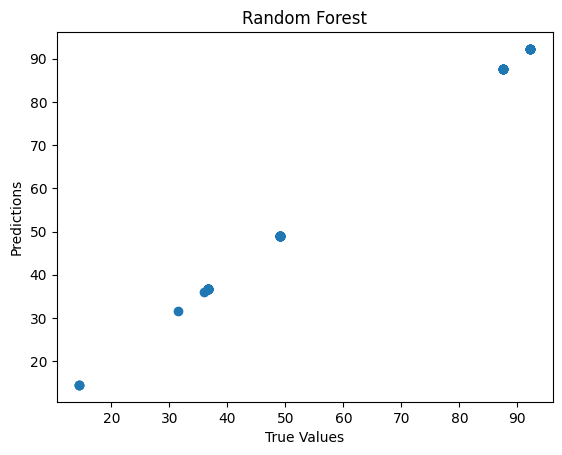

In [24]:
# plotting the results
plot_predictions(y_test, rf_y_pred, 'Random Forest', 'WORKORDER_WORKORDERINGROUTING_ActualCost' ,'rf')

In [25]:
# dataframe with the predictions and the actual values, plus other metrics
rf_results = pd.DataFrame({'Actual': y_test, 'Predicted': rf_y_pred})
rf_results['Difference'] = rf_results['Actual'] - rf_results['Predicted']
rf_results['Absolute Difference'] = np.abs(rf_results['Difference'])
rf_results['Squared Difference'] = rf_results['Difference'] ** 2

rf_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
268,36.75,36.75,0.0,0.0,0.0
250,36.75,36.75,0.0,0.0,0.0
318,49.00,49.00,0.0,0.0,0.0
331,36.75,36.75,0.0,0.0,0.0
56,36.75,36.75,0.0,0.0,0.0
...,...,...,...,...,...
104,87.50,87.50,0.0,0.0,0.0
167,87.50,87.50,0.0,0.0,0.0
63,49.00,49.00,0.0,0.0,0.0
233,36.75,36.75,0.0,0.0,0.0


In [26]:
# printing the average absolute difference
print(f'Average Absolute Difference: {rf_results["Absolute Difference"].mean()}')

Average Absolute Difference: 0.00029220779220780327


C:\Users\alexb\Desktop\United-Outdoors\visualization\static\training\prediction\WORKORDER_WORKORDERINGROUTING_ActualCost\rf_feature_importance.png


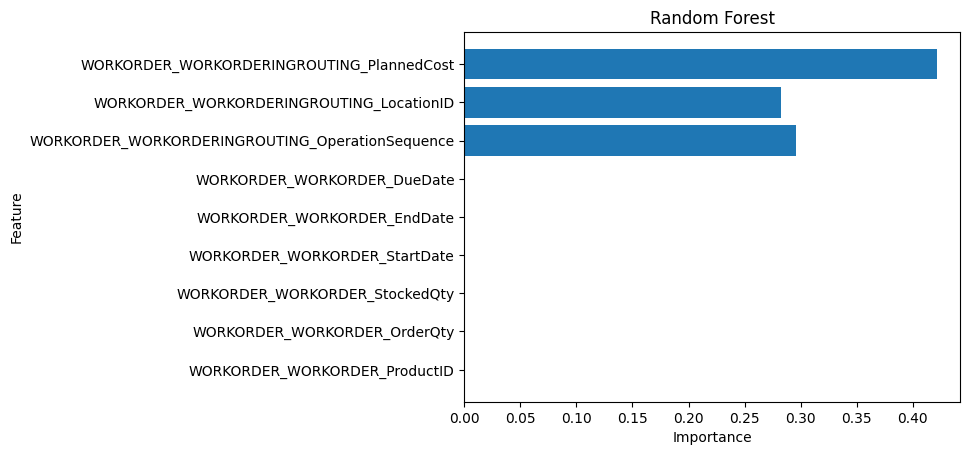

In [27]:
# plotting the feature importances, which means how much each column contributes to the predictions
plot_feature_importance(X.columns, rf_model.feature_importances_, 'Random Forest', 'WORKORDER_WORKORDERINGROUTING_ActualCost' ,'rf')

## Gradient Boosting

In [28]:
# fitting the model
gb_model = GradientBoostingRegressor(n_estimators=100)

gb_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor()

In [29]:
# predicting the values
gb_y_pred = gb_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [30]:
# calculating the metrics
dtr_mse = mean_squared_error(y_test, dtr_y_pred)
dtr_r2 = r2_score(y_test, dtr_y_pred)
print(f'Mean Squared Error: {dtr_mse}')
print(f'R2 Score: {dtr_r2}')

Mean Squared Error: 0.0
R2 Score: 1.0


C:\Users\alexb\Desktop\United-Outdoors\visualization\static\training\prediction\WORKORDER_WORKORDERINGROUTING_ActualCost\gb_scatter.png


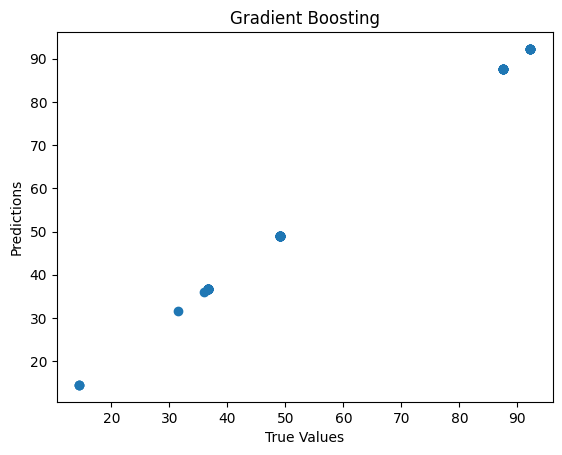

In [31]:
# plotting the results
plot_predictions(y_test, gb_y_pred, 'Gradient Boosting', 'WORKORDER_WORKORDERINGROUTING_ActualCost' ,'gb')

In [32]:
# dataframe with the predictions and the actual values, plus other metrics
gb_results = pd.DataFrame({'Actual': y_test, 'Predicted': gb_y_pred})
gb_results['Difference'] = gb_results['Actual'] - gb_results['Predicted']
gb_results['Absolute Difference'] = np.abs(gb_results['Difference'])
gb_results['Squared Difference'] = gb_results['Difference'] ** 2

gb_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
268,36.75,36.750317,-0.000317,0.000317,1.003297e-07
250,36.75,36.750317,-0.000317,0.000317,1.003297e-07
318,49.00,49.000046,-0.000046,0.000046,2.106492e-09
331,36.75,36.750317,-0.000317,0.000317,1.003297e-07
56,36.75,36.750317,-0.000317,0.000317,1.003297e-07
...,...,...,...,...,...
104,87.50,87.499023,0.000977,0.000977,9.539767e-07
167,87.50,87.499023,0.000977,0.000977,9.539767e-07
63,49.00,49.000046,-0.000046,0.000046,2.106492e-09
233,36.75,36.750317,-0.000317,0.000317,1.003297e-07


In [33]:
# printing the average absolute difference
print(f'Average Absolute Difference: {gb_results["Absolute Difference"].mean()}')

Average Absolute Difference: 0.00046085241904130674


C:\Users\alexb\Desktop\United-Outdoors\visualization\static\training\prediction\WORKORDER_WORKORDERINGROUTING_ActualCost\gb_feature_importance.png


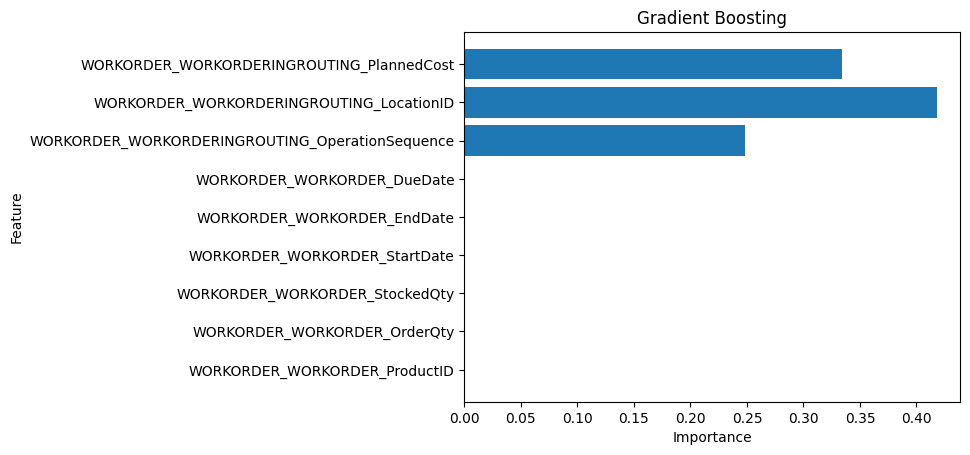

In [34]:
# plotting the feature importances, which means how much each column contributes to the predictions
plot_feature_importance(X.columns, gb_model.feature_importances_, 'Gradient Boosting','WORKORDER_WORKORDERINGROUTING_ActualCost' ,'gb')

### Pytorch Neural Network

In [35]:
# check if the GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# converting the data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

Using device: cpu


In [36]:
# instantiate the model
p_model = torch.nn.Sequential(
    torch.nn.Linear(X_train_tensor.shape[1], 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1)
).to(device)

# define the loss function and the optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(p_model.parameters(), lr=0.01)

# Create TensorDatasets for training and test data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for training and test data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Train the model
train_model(p_model, criterion, optimizer, train_loader, num_epochs=1000)

Epoch 0, Loss: 1.3595977626762301e+28
Epoch 100, Loss: 1.3849225154730773e+28
Epoch 200, Loss: 1.392422814039495e+28
Epoch 300, Loss: 1.3691828679856727e+28
Epoch 400, Loss: 1.3619537513145338e+28
Epoch 500, Loss: 1.3977600326384343e+28
Epoch 600, Loss: 1.3779090928910434e+28
Epoch 700, Loss: 1.3747295235381273e+28
Epoch 800, Loss: 1.3723500411265713e+28
Epoch 900, Loss: 1.383338869873047e+28


#### Calculating the metrics and visualizing the results

In [37]:
# Evaluate the model
p_model.eval()
p_mse_list = []
p_r2_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = p_model(inputs)
        mse = mean_squared_error(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        p_mse_list.append(mse)
        
        # Only calculate R^2 score if there are more than one samples
        if len(targets) > 1:
            r2 = r2_score(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
            p_r2_list.append(r2)

# Calculate the average metrics
p_avg_mse = np.mean(p_mse_list)
p_avg_r2 = np.mean(p_r2_list) if p_r2_list else None

print(f'Average Mean Squared Error: {p_avg_mse}')
print(f'Average R2 Score: {p_avg_r2}')

Average Mean Squared Error: 1.3597890185187864e+28
Average R2 Score: -2.692457557653863e+25


## WTF

In [38]:
# dataframe with the predictions and the actual values, plus other metrics
p_results = pd.DataFrame({'Actual': y_test_tensor.cpu().detach().numpy(), 'Predicted': p_model(X_test_tensor).cpu().detach().numpy().flatten()})
p_results['Difference'] = p_results['Actual'] - p_results['Predicted']
p_results['Absolute Difference'] = np.abs(p_results['Difference'])
p_results['Squared Difference'] = p_results['Difference'] ** 2

p_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
0,36.75,1.186699e+14,-1.186699e+14,1.186699e+14,1.408256e+28
1,36.75,1.186699e+14,-1.186699e+14,1.186699e+14,1.408256e+28
2,49.00,1.202269e+14,-1.202269e+14,1.202269e+14,1.445450e+28
3,36.75,1.202269e+14,-1.202269e+14,1.202269e+14,1.445450e+28
4,36.75,1.139884e+14,-1.139884e+14,1.139884e+14,1.299336e+28
...,...,...,...,...,...
72,87.50,1.155539e+14,-1.155539e+14,1.155539e+14,1.335271e+28
73,87.50,1.168747e+14,-1.168747e+14,1.168747e+14,1.365968e+28
74,49.00,1.145146e+14,-1.145146e+14,1.145146e+14,1.311359e+28
75,36.75,1.181417e+14,-1.181417e+14,1.181417e+14,1.395745e+28
